In [42]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from scipy import interp
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import TruncatedSVD
from collections import Counter

# Goal: We want to predict the star that user is going to give the restaurant based on the review and restaurant's information

# Preprocess Data

In [2]:
# read in the data
df = pd.read_csv('complete_nlp.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127327 entries, 0 to 127326
Data columns (total 47 columns):
Unnamed: 0                    127327 non-null int64
business_id                   127327 non-null object
stars                         127327 non-null float64
BikeParking                   88373 non-null object
BusinessAcceptsCreditCards    117514 non-null object
BusinessParking               93323 non-null object
GoodForKids                   71203 non-null object
HasTV                         58744 non-null object
NoiseLevel                    57762 non-null object
OutdoorSeating                61561 non-null object
RestaurantsAttire             53041 non-null object
RestaurantsDelivery           56307 non-null object
RestaurantsGoodForGroups      59566 non-null object
RestaurantsPriceRange2        93788 non-null float64
RestaurantsReservations       56463 non-null object
RestaurantsTakeOut            61741 non-null object
Alcohol                       60486 non-null object


In [3]:
# drop columns that are not useable
df.drop(columns=['Unnamed: 0','business_id','BusinessParking','text'],inplace=True)
df.head()

,stars,BikeParking,BusinessAcceptsCreditCards,GoodForKids,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,...,BusinessAcceptsBitcoin,HairSpecializesIn,AgesAllowed,RestaurantsCounterService,Open24Hours,DietaryRestrictions,useful,review_stars,count(checkins),sentiments
0,4.0,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11,4,47,0.6
1,4.0,False,True,False,False,average,False,dressy,False,True,...,NaN,NaN,NaN,NaN,False,NaN,9,4,140,0.4
2,4.0,False,True,False,False,average,False,dressy,False,True,...,NaN,NaN,NaN,NaN,False,NaN,17,4,140,0.4
3,4.0,False,True,False,False,average,False,dressy,False,True,...,NaN,NaN,NaN,NaN,False,NaN,10,4,140,0.2
4,4.0,False,True,False,False,average,False,dressy,False,True,...,NaN,NaN,NaN,NaN,False,NaN,12,4,140,0.5


In [4]:
# drop reviews that are not honest
a = df['review_stars']
RS_scale = np.interp(a, (a.min(), a.max()), (-1, +1))
drop_index = df[abs(RS_scale - df['sentiments']) > 1.5].index
df.drop(index=drop_index,inplace=True)

In [5]:
# take out the numeric coutinuous value and store it
countinuous_col = ['useful','count(checkins)','sentiments']
df_num = df[countinuous_col]
df.drop(columns=countinuous_col,inplace = True)

In [8]:
# convert categotical values to string
df = df.fillna("NA")
df = df.astype(str)
df.head()

,stars,BikeParking,BusinessAcceptsCreditCards,GoodForKids,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,...,Smoking,ByAppointmentOnly,AcceptsInsurance,BusinessAcceptsBitcoin,HairSpecializesIn,AgesAllowed,RestaurantsCounterService,Open24Hours,DietaryRestrictions,review_stars
0,4.0,True,True,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,4
1,4.0,False,True,False,False,average,False,dressy,False,True,...,NA,NA,NA,NA,NA,NA,NA,False,NA,4
2,4.0,False,True,False,False,average,False,dressy,False,True,...,NA,NA,NA,NA,NA,NA,NA,False,NA,4
3,4.0,False,True,False,False,average,False,dressy,False,True,...,NA,NA,NA,NA,NA,NA,NA,False,NA,4
4,4.0,False,True,False,False,average,False,dressy,False,True,...,NA,NA,NA,NA,NA,NA,NA,False,NA,4


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127314 entries, 0 to 127326
Data columns (total 40 columns):
stars                         127314 non-null object
BikeParking                   127314 non-null object
BusinessAcceptsCreditCards    127314 non-null object
GoodForKids                   127314 non-null object
HasTV                         127314 non-null object
NoiseLevel                    127314 non-null object
OutdoorSeating                127314 non-null object
RestaurantsAttire             127314 non-null object
RestaurantsDelivery           127314 non-null object
RestaurantsGoodForGroups      127314 non-null object
RestaurantsPriceRange2        127314 non-null object
RestaurantsReservations       127314 non-null object
RestaurantsTakeOut            127314 non-null object
Alcohol                       127314 non-null object
Caters                        127314 non-null object
DogsAllowed                   127314 non-null object
DriveThru                     127314 non-

In [10]:
# join the two data set
df_complete = df.join(df_num)

In [11]:
# there are some NAs in sentiments, drop those samples
df_complete.dropna(subset=['sentiments'],inplace=True)

In [12]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127312 entries, 0 to 127326
Data columns (total 43 columns):
stars                         127312 non-null object
BikeParking                   127312 non-null object
BusinessAcceptsCreditCards    127312 non-null object
GoodForKids                   127312 non-null object
HasTV                         127312 non-null object
NoiseLevel                    127312 non-null object
OutdoorSeating                127312 non-null object
RestaurantsAttire             127312 non-null object
RestaurantsDelivery           127312 non-null object
RestaurantsGoodForGroups      127312 non-null object
RestaurantsPriceRange2        127312 non-null object
RestaurantsReservations       127312 non-null object
RestaurantsTakeOut            127312 non-null object
Alcohol                       127312 non-null object
Caters                        127312 non-null object
DogsAllowed                   127312 non-null object
DriveThru                     127312 non-

In [13]:
df_complete.columns

Index(['stars', 'BikeParking', 'BusinessAcceptsCreditCards', 'GoodForKids',
       'HasTV', 'NoiseLevel', 'OutdoorSeating', 'RestaurantsAttire',
       'RestaurantsDelivery', 'RestaurantsGoodForGroups',
       'RestaurantsPriceRange2', 'RestaurantsReservations',
       'RestaurantsTakeOut', 'Alcohol', 'Caters', 'DogsAllowed', 'DriveThru',
       'GoodForMeal', 'RestaurantsTableService', 'WheelchairAccessible',
       'WiFi', 'Ambience', 'BYOB', 'BYOBCorkage', 'BestNights', 'CoatCheck',
       'Corkage', 'GoodForDancing', 'HappyHour', 'Music', 'Smoking',
       'ByAppointmentOnly', 'AcceptsInsurance', 'BusinessAcceptsBitcoin',
       'HairSpecializesIn', 'AgesAllowed', 'RestaurantsCounterService',
       'Open24Hours', 'DietaryRestrictions', 'review_stars', 'useful',
       'count(checkins)', 'sentiments'],
      dtype='object')

In [14]:
columns = ['review_stars','stars', 'BikeParking', 'BusinessAcceptsCreditCards', 'GoodForKids',
       'HasTV', 'NoiseLevel', 'OutdoorSeating', 'RestaurantsAttire',
       'RestaurantsDelivery', 'RestaurantsGoodForGroups',
       'RestaurantsPriceRange2', 'RestaurantsReservations',
       'RestaurantsTakeOut', 'Alcohol', 'Caters', 'DogsAllowed', 'DriveThru',
       'GoodForMeal', 'RestaurantsTableService', 'WheelchairAccessible',
       'WiFi', 'Ambience', 'BYOB', 'BYOBCorkage', 'BestNights', 'CoatCheck',
       'Corkage', 'GoodForDancing', 'HappyHour', 'Music', 'Smoking',
       'ByAppointmentOnly', 'AcceptsInsurance', 'BusinessAcceptsBitcoin',
       'HairSpecializesIn', 'AgesAllowed', 'RestaurantsCounterService',
       'Open24Hours', 'DietaryRestrictions',  'useful',
       'count(checkins)', 'sentiments']

In [15]:
# rearrange the columns
df_complete = df_complete.reindex(columns = columns)

In [16]:
df_complete.head()

,review_stars,stars,BikeParking,BusinessAcceptsCreditCards,GoodForKids,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,...,AcceptsInsurance,BusinessAcceptsBitcoin,HairSpecializesIn,AgesAllowed,RestaurantsCounterService,Open24Hours,DietaryRestrictions,useful,count(checkins),sentiments
0,4,4.0,True,True,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,11,47,0.6
1,4,4.0,False,True,False,False,average,False,dressy,False,...,NA,NA,NA,NA,NA,False,NA,9,140,0.4
2,4,4.0,False,True,False,False,average,False,dressy,False,...,NA,NA,NA,NA,NA,False,NA,17,140,0.4
3,4,4.0,False,True,False,False,average,False,dressy,False,...,NA,NA,NA,NA,NA,False,NA,10,140,0.2
4,4,4.0,False,True,False,False,average,False,dressy,False,...,NA,NA,NA,NA,NA,False,NA,12,140,0.5


In [30]:
# encode the categorical variable to foat arrays
enc_y = OneHotEncoder(handle_unknown='ignore')
Y = enc_y.fit_transform(df_complete['review_stars'].values.reshape(len(df_complete['review_stars']),1))

In [31]:
# encode X variable
enc_x = OneHotEncoder(handle_unknown='ignore')
x = df_complete.loc[:,'stars':]
X = enc_x.fit_transform(x).toarray()

In [32]:
Y.shape

(127312, 5)

In [33]:
# split the training and testing set
x_train, x_test, y_train, y_test = train_test_split(X,Y)

In [34]:
x_train.shape

(95484, 984)

# Neural Net

In [23]:
# initialize and compile the model
model = Sequential()
# input layer
model.add(Dense(units=985, activation='sigmoid', input_dim=984))

# Hidden layers
model.add(Dense(units=3, activation='sigmoid'))
model.add(Dense(units=3, activation='sigmoid'))

# output layer
model.add(Dense(units=5, activation='softmax'))

# Stochastic gradient descent optimizer.
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
# compile the model
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
# train
hist = model.fit(x_train,y_train,epochs=100)

Epoch 1/100
95484/95484 [==============================] - 20s 212us/step - loss: 1.4754 - acc: 0.3398
Epoch 2/100
95484/95484 [==============================] - 20s 209us/step - loss: 1.1439 - acc: 0.5047
Epoch 3/100
95484/95484 [==============================] - 20s 209us/step - loss: 0.9804 - acc: 0.5589
Epoch 4/100
95484/95484 [==============================] - 21s 220us/step - loss: 0.9511 - acc: 0.5749
Epoch 5/100
95484/95484 [==============================] - 21s 223us/step - loss: 0.9394 - acc: 0.5824
Epoch 6/100
95484/95484 [==============================] - 22s 229us/step - loss: 0.9290 - acc: 0.5867
Epoch 7/100
95484/95484 [==============================] - 20s 210us/step - loss: 0.9197 - acc: 0.5928
Epoch 8/100
95484/95484 [==============================] - 20s 210us/step - loss: 0.9140 - acc: 0.5973
Epoch 9/100
95484/95484 [==============================] - 21s 217us/step - loss: 0.9115 - acc: 0.5973
Epoch 10/100
95484/95484 [==============================] - 21s 219us/ste

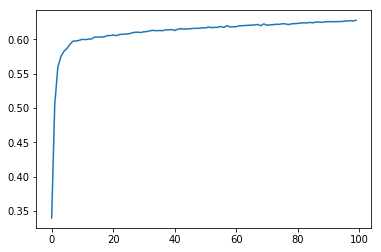

In [64]:
plt.plot(hist.history['acc'])

**save model in case of computer crush**

In [90]:
model_json = model.to_json()
with open("model.json",'w') as json_file:
    json_file.write(model_json)

In [91]:
model.save_weights("model_weights.h5")

In [92]:
np.savetxt("hist1.csv",hist.history['acc'],delimiter=",")
#np.savetxt("hist2.csv",hist2.history['acc'],delimiter=",")

**read model**

In [24]:
model.load_weights("model_weights.h5")

In [25]:
# evaluate the model
model.evaluate(x_test,y_test)

31828/31828 [==============================] - 2s 64us/step


[0.8438019116005436, 0.6278748272111612]

In [26]:
model.metrics_names

['loss', 'acc']

Text(0.5, 1.0, 'Original star distribution')

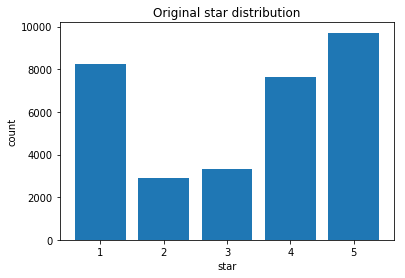

In [69]:
# Original star distribution
y_roginal = enc_y.inverse_transform(y_test).ravel()
c = Counter(y_roginal)
x = list(c.keys())
x = np.asarray(x)
results = list(map(int, x))
plt.bar(results,c.values())
plt.xlabel("star")
plt.ylabel("count")
plt.title('Original star distribution')

Text(0.5, 1.0, 'predicted star distribution')

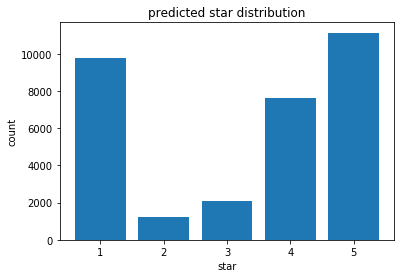

In [70]:
# predicted star distribution
y_predic = model.predict_classes(x_test)
c = Counter(y_predic)
x = list(c.keys())
x = np.asarray(x) + 1
plt.bar(x ,c.values())
plt.xlabel("star")
plt.ylabel("count")
plt.title('predicted star distribution')

**model has 84.3% loss and 62.8% accuracy** 

# Logistic regression

In [40]:
# encode y to labels that logistic regressor can accept
y_train_origin = enc_y.inverse_transform(y_train)
y_test_origin = enc_y.inverse_transform(y_test)
y_train_logis = LabelEncoder().fit_transform(y_train_origin.ravel())
y_test_logis = LabelEncoder().fit_transform(y_test_origin.ravel())

In [41]:
logi = LogisticRegression(penalty='l1').fit(x_train,y_train_logis)

/home/xingwei/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xingwei/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [43]:
logi.score(x_test,y_test_logis)

0.613910530283991

# SVM with cross validation

In [21]:
def svm_with_cv(X, Y, name, choosefeature):
    """
    Takes in X and Y to perform SVM with cross validation and plot ROC, PR curve.
    param:
        X: X matrix
        Y: Y matrix
        name: the name of the data(str)
        choosefeature: wether or not to choose feature(bool)
    returns:
    feature number selected.
    """
    # encode y
    enc_y = LabelBinarizer()
    y = enc_y.fit_transform(Y)

    enc_y2 = LabelEncoder()
    y2 = enc_y2.fit_transform(Y)
    n_classes = enc_y2.classes_.shape[0]

    # choose feature
    if choosefeature:
        clf_logi = LogisticRegression(penalty='l1')
        selected = SelectFromModel(clf_logi).fit(X, y2)
        index = np.argwhere(selected.get_support() == True)
        index = index.ravel()
        X = X[:, index]
        feature_num = len(index)

    cv2 = StratifiedKFold(n_splits=n_classes)
    # cv = KFold(n_splits=n_classes)
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    average_precisions = []
    mean_recall = np.linspace(0, 1, 100)
    # recalls = []

    for train, test in cv2.split(X, y2):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        recall, precision, _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
        precisions.append(interp(mean_recall, recall, precision))
        average_precision = average_precision_score(y_test.ravel(), y_score.ravel())
        average_precisions.append(average_precision)

    plt.figure(1, figsize=(8, 6))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8, label='Mean ROC for {}(AUC = {})'.format(name, round(mean_auc, 2)))
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.show()

    plt.figure(2, figsize=(8, 6))
    mean_precision = np.mean(precisions, axis=0)
    AUPRC = np.mean(average_precisions)
    # average_precision = average_precision_score(mean_recall, mean_precision)
    plt.plot(mean_recall, mean_precision, label="Mean PR for {}(AUPRC = {})".format(name, round(AUPRC, 2)))
    plt.legend(loc='upper right')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR Curve")
    plt.show()
    try:
        print("the number of features for {} are {}".format(name, feature_num))
    except:
        pass



In [32]:
# preprocess data
Y = df_complete.loc[:5000,'review_stars']
X = df_complete.loc[:5000,'stars':]
X = enc_x.fit_transform(X)
X.shape

(5001, 516)

**Due to computation power constrain, we can only perform SVM on 5000 data samples**

/home/xingwei/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xingwei/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


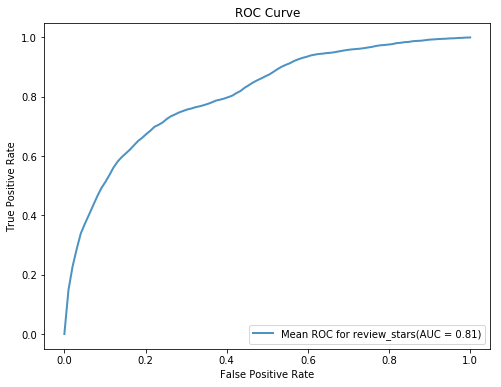

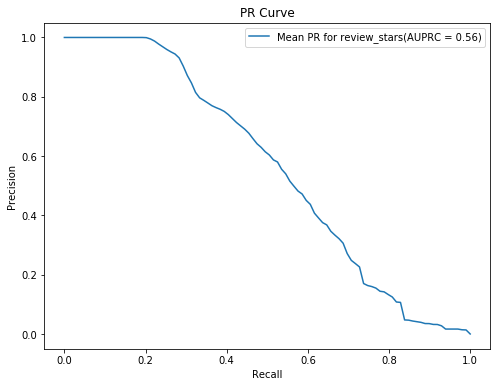

the number of features for review_stars are 373


In [33]:
svm_with_cv(X, Y, 'review_stars', True)

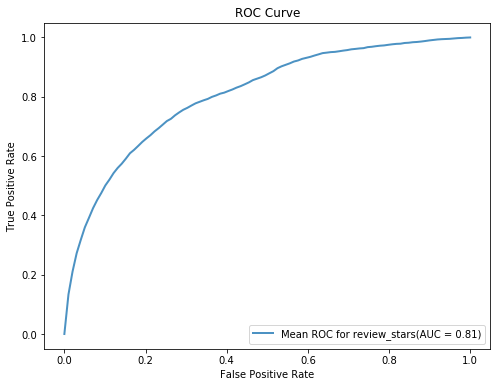

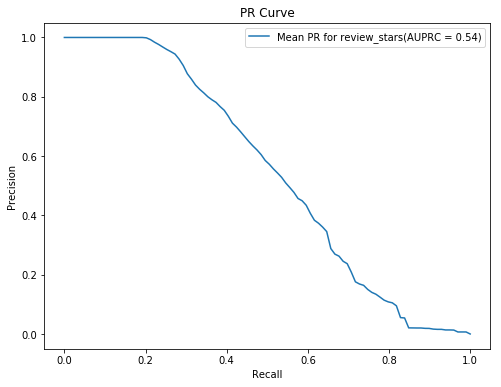

In [34]:
# svm without feature selection
svm_with_cv(X, Y, 'review_stars', False)

# SVD dimension reduction

In [81]:
# preprocess data
Y = df_complete.loc[:5000,'review_stars']
X = df_complete.loc[:5000,'stars':]
X = enc_x.fit_transform(X)
X.shape

(5001, 516)

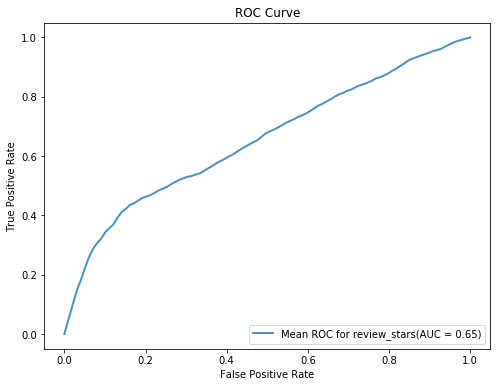

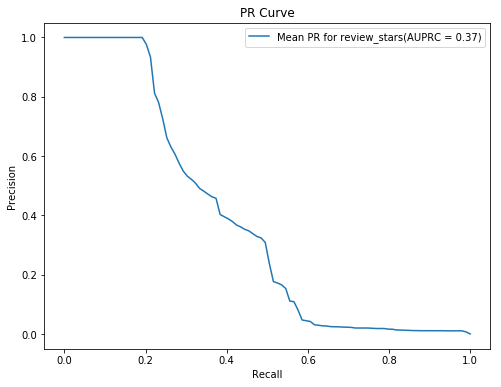

In [89]:
svd = TruncatedSVD(n_components=20, random_state=42)
reduced_X = svd.fit_transform(X)

svm_with_cv(reduced_X, Y, 'review_stars', False)

**conclusion: dimension reduction doesn't maintain or improve model accuracy.**